In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph
from losses import GraphLoss

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
DATA_PATH = '../matrix_dataset/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

train_A_chars = list(train_A_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')

A_train_ds = P300Getter(train_A_raw, eloc, sample_size=72)
A_test_ds = P300Getter(test_A_raw, eloc, sample_size=72, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

A_train_ds.upsample(4)
#A_test_ds.upsample(2)

X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.15it/s]


In [7]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 1024

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True)
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True)

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [8]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph
from losses import GraphLoss

In [80]:
res = []

for alpha in tqdm(np.logspace(-2, 0, 3)):
    for beta in np.logspace(-2, 0, 3):
        for gamma in np.logspace(-2, 0, 3):
            criterion = GraphLoss(alpha, beta, gamma)

            learning_params = {
                'num_epochs' : 150,
                'lr' : 1e-4,
                'weight_decay' : 1e-2,
                'step_size' : 5,
                'gamma' : 1,
                'num_classes' : 2,
                'model_type' : 'CNN'
              }

            torch.manual_seed(44)
            np.random.seed(44)
            my_device = torch.device('cuda:0')
            model_GNN = EdgeLearnGNN(48, 64)

            loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
            res.append([alpha, beta, gamma, acc['Accuracy'].max(), acc['F1-score'].max()])

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Training complete in 4m 56s
Training complete in 4m 59s
Training complete in 4m 54s
Training complete in 4m 50s
Training complete in 4m 54s
Training complete in 4m 59s
Training complete in 4m 54s
Training complete in 4m 56s


 33%|█████████████▋                           | 1/3 [44:15<1:28:31, 2655.78s/it]

Training complete in 4m 55s
Training complete in 4m 56s
Training complete in 4m 50s
Training complete in 4m 50s
Training complete in 4m 50s
Training complete in 4m 46s
Training complete in 4m 45s
Training complete in 4m 45s
Training complete in 4m 48s


 67%|███████████████████████████▎             | 2/3 [1:27:29<43:39, 2619.26s/it]

Training complete in 4m 45s
Training complete in 4m 45s
Training complete in 4m 47s
Training complete in 4m 46s
Training complete in 4m 47s
Training complete in 4m 46s
Training complete in 4m 46s
Training complete in 4m 45s
Training complete in 4m 47s


100%|█████████████████████████████████████████| 3/3 [2:10:24<00:00, 2608.18s/it]

Training complete in 4m 47s


Training complete in 8m 34s
Accuracy:  0.6153888888888889
F1-score:  0.28224719101123596


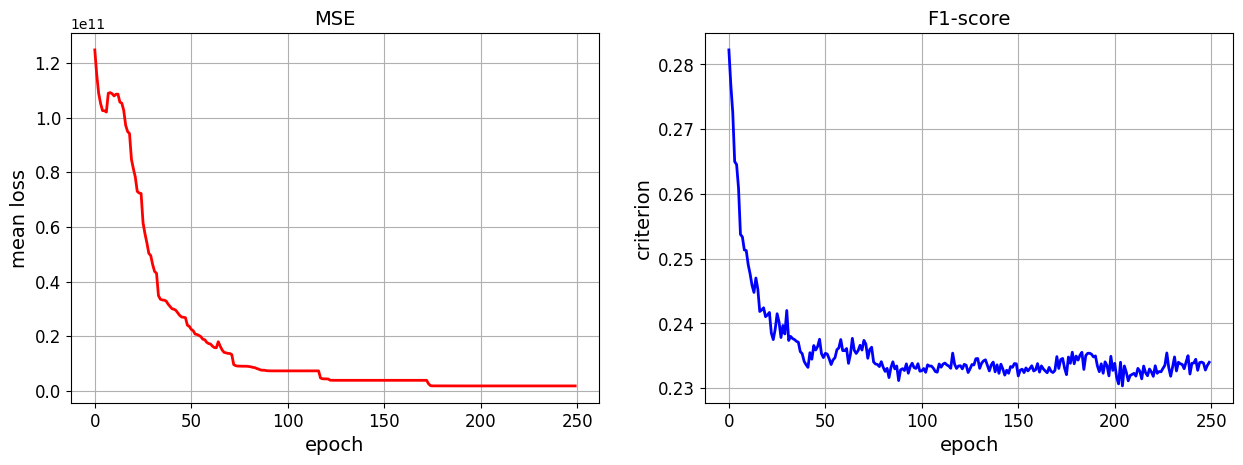

In [9]:
criterion = GraphLoss(F.mse_loss, 0.01, 0.10, 0.0001)

learning_params = {
    'num_epochs' : 250,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')
model_GNN = EdgeLearnGNN(48, 64)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

Training complete in 8m 51s
Accuracy:  0.6775555555555556
F1-score:  0.2510653409090909


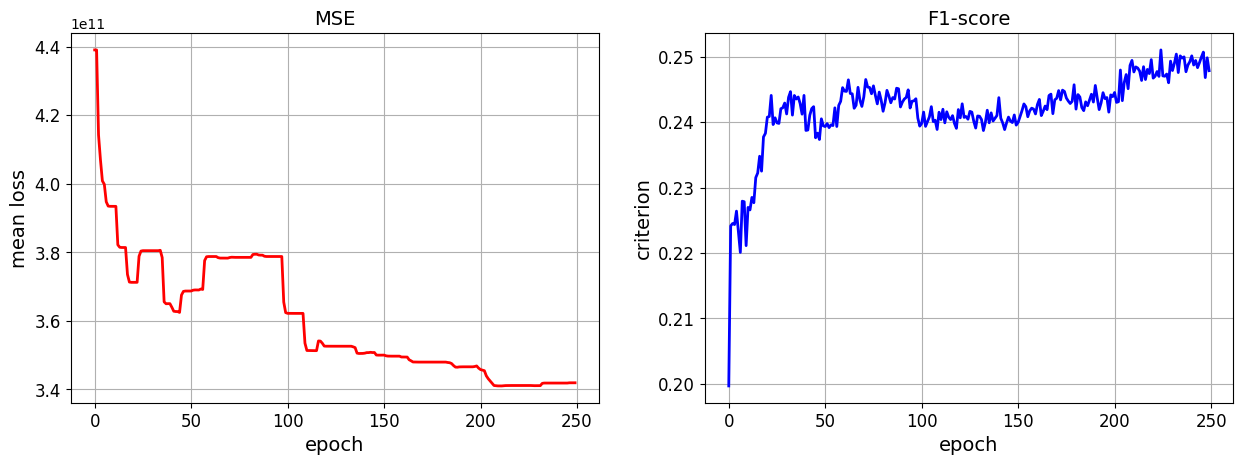

In [10]:
criterion = GraphLoss(F.mse_loss, 0.01, 0.10, 0.0001)

learning_params = {
    'num_epochs' : 250,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')
model_GNN = PairEdgeLearnGNN(48, 64)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

Training complete in 8m 47s
Accuracy:  0.6743888888888889
F1-score:  0.25088243279934835


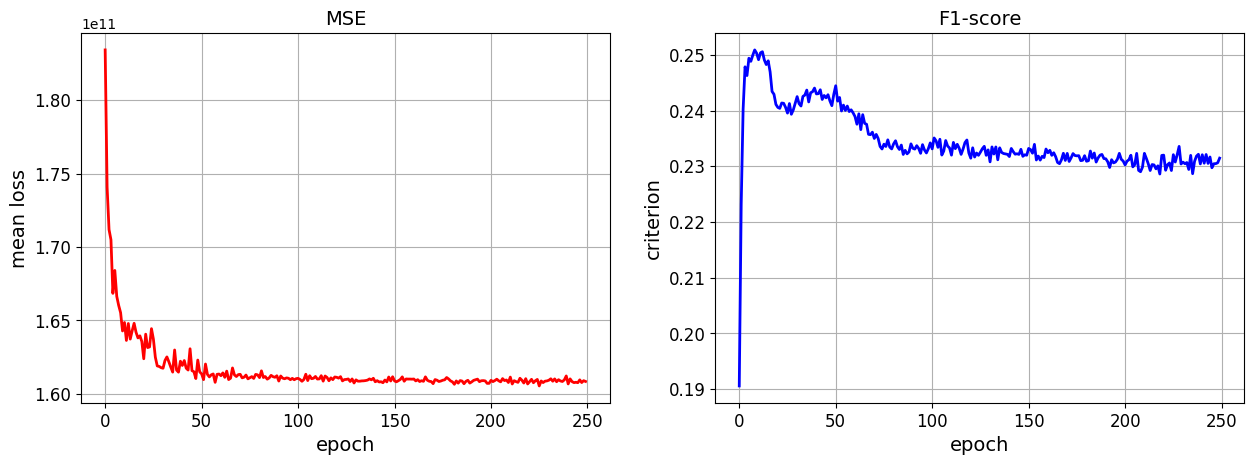

In [11]:
criterion = GraphLoss(F.mse_loss, 0.01, 0.10, 0.0001)

learning_params = {
    'num_epochs' : 250,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')
model_GNN = PairEdgeReluLearnGNN(48, 64)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

Training complete in 8m 23s
Accuracy:  0.8333333333333334
F1-score:  nan


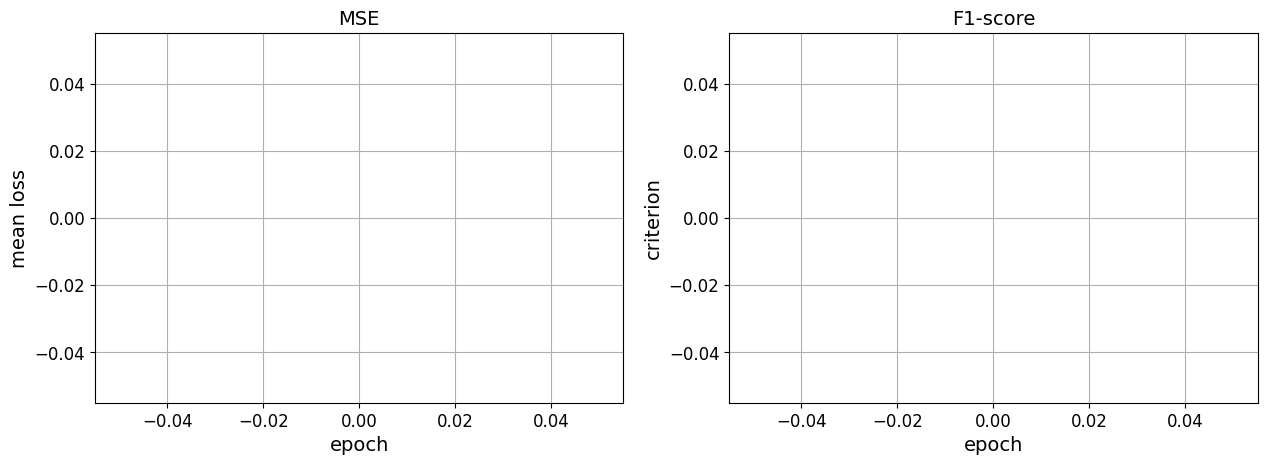

In [12]:
criterion = GraphLoss(F.mse_loss, 0.01, 0.10, 0.0001)

learning_params = {
    'num_epochs' : 250,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
model_GNN = PriorEdgeLearnGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')